## Differentially flat trajectory generation for quadcopter

Recall from the previous notebook that for the quadcopter we have the following state and control vectors:

$$\vec{x} = [x, y, z, \phi, \theta, \psi, \dot{x}, \dot{y}, \dot{z}, \dot{\phi}, \dot{\theta}, \dot{\psi}]^T$$
$$\vec{u} = [\omega_1^2, \omega_2^2, \omega_3^2, \omega_4^2]^T$$


A system is *differentially flat* if its state and control inputs can be expressed as a function of a finite number of variables, called *flat outputs*, and a finite number of derivatives of the flat outputs. This is quite powerful, because for a differentially flat system, if one can determine how the flat outputs should vary, then one can completely determine how the state **and** the control inputs should vary.

It turns out that the quadcopter is differentially flat [1, 2]. One set of flat outputs for this sytem are $\sigma(t) = [x(t), y(t), z(t), \psi(t)]$. Thus, if we can determine a desired trajectory in $\sigma(t)$, we can obtain the control inputs that should make the quadcopter exactly follow $\sigma(t)$, which of course includes the linear position $(x(t),y(t),z(t))$.

We will not go into the details of differential flatness; interested readers may refer to [1, 2, 3]. Given $\sigma(t) = [x(t), y(t), z(t), \psi(t)]$ and up to fourth-order dervatives of $\sigma(t)$, the algorithm of [1] to compute the state and control inputs is implemented in `./dynamics/trajectory_generation.py`. In this notebook, we demonstrate how to use it to generate a trajectory for the quadcopter.

In [1]:
import matplotlib.pyplot as plt

from math import ceil

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import collimator

from collimator import logging

logging.set_log_level(logging.ERROR)

from collimator.logging import logger

from collimator.framework import LeafSystem
from collimator.library import SourceBlock, Clock
from collimator.simulation import SimulatorOptions

from collimator.models.quadcopter import (
    differentially_flat_state_and_control,
    make_quadcopter,
    animate_quadcopter,
    plot_sol,
)

### Quadcopter configuration

We set the inertia compoments $(I_{xx}, I_{yy}, I_{zz})$, rotor force and torque generation parameters $(k, b)$,  length $l$, mass $m$, and gravity $g$ to generate a quadcopter configuration.

In [2]:
nvars = 6  # x, y, z, phi, theta, psi
nstate = 12  # the 6 vars above and their derivatives
ncontrol = (
    4  # u_i = (\omega_i)**2, where \omega_i is the angular velocity of the rotor_i
)

# Quadcopter configuration
config = {
    "Ixx": 1.0,
    "Iyy": 1.0,
    "Izz": 2.0,
    "k": 1.0,
    "b": 0.5,
    "l": 1.0 / 3,
    "m": 2.0,
    "g": 9.81,
}

### Differentially flat inputs

Our goal is to use the differentially flat property of the quadcopter to make it follow a desired trajectory. For example, the [leminscate](https://en.wikipedia.org/wiki/Lemniscate) trajectory is quite common for quadcopter demonsrations. The leminscate trajectory defines $(x(t),y(t),z(t))$ for the quadcopter. We also need the yaw angle $\psi(t)$, which we can set to zero at all times. With this our definition of $\sigma(t) = [x(t), y(t), z(t), \psi(t)]$ is complete. However, the complete set of flat outputs also includes derivatives of $\sigma(t)$ up to fourth order. We easily obtain these with JAX's automatic differentiation framework, thus obtaining a complete set of flat outputs that we can use in the algorithm of [1]. This is demonstrated below.

In [3]:
# \sigma is the differentially flat input \sigma = [x, y, z, \psi]


def get_sigma_leminscate(t):
    """The Leminscate trajectory (shape of eight) in the x-y plane"""
    tfac = 1.2
    x = 2.0 * jnp.cos(jnp.sqrt(2) * t / tfac)
    y = 2.0 * jnp.sin(jnp.sqrt(2) * t / tfac) * jnp.cos(jnp.sqrt(2) * t / tfac)
    z = 0.0
    # z = jnp.sin(jnp.sqrt(2)*t/tfac)

    phi = 0.0
    return jnp.array([x, y, z, phi])


def get_sigma_circle(t):
    """Circular trajectory in the x-y plane"""
    tfac = 1.2
    x = 2.0 * jnp.cos(jnp.sqrt(2) * t / tfac)
    y = 2.0 * jnp.sin(jnp.sqrt(2) * t / tfac)
    z = 0.0

    phi = 0.0
    return jnp.array([x, y, z, phi])


# pick one of leminscate or circle trajectory
get_sigma = get_sigma_leminscate
# get_sigma = get_sigma_circle

# Functions to compute up to 4th order derivatives by automatic differentiation
get_sigma_d1 = jax.jacobian(get_sigma)
get_sigma_d2 = jax.jacobian(get_sigma_d1)
get_sigma_d3 = jax.jacobian(get_sigma_d2)
get_sigma_d4 = jax.jacobian(get_sigma_d3)


# function to get sigma and up to 4th order derivatives
def get_flat_inputs(t, config):
    flat_inputs = differentially_flat_state_and_control(
        get_sigma(t),
        get_sigma_d1(t),
        get_sigma_d2(t),
        get_sigma_d3(t),
        get_sigma_d4(t),
        **config,
    )
    return flat_inputs


# function to generate the trajectory
generate_trajectory = jax.vmap(get_flat_inputs, (0, None))

We can use the above function to generate a trajectory and visualise the results for both the state and the control vector.

In [4]:
Tref = 5.5
t_ref = jnp.linspace(0.0, Tref, ceil(Tref * 500))
x_and_u_ref = generate_trajectory(t_ref, config)

x_ref = x_and_u_ref[:, :nstate]
u_ref = x_and_u_ref[:, nstate:]

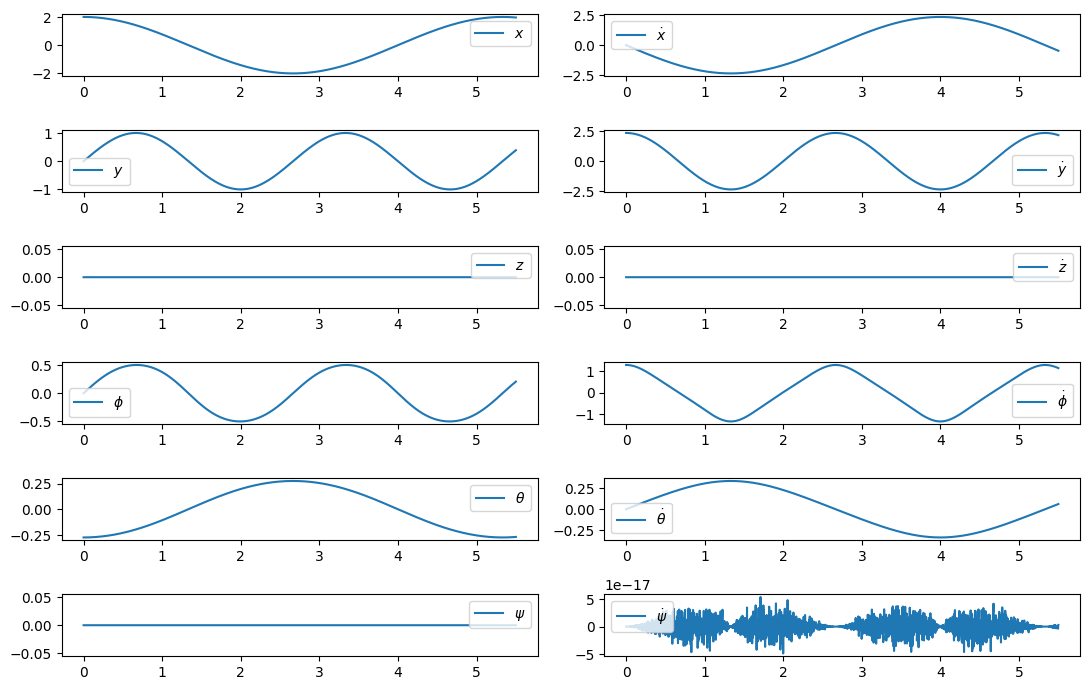

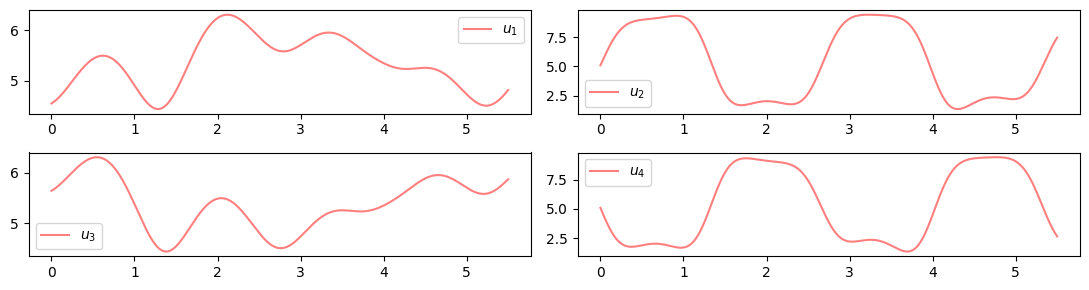

In [5]:
state_names = [r"$x$", r"$y$", r"$z$", r"$\phi$", r"$\theta$", r"$\psi$"]
state_names = state_names + [r"$\dot{" + name[1:-1] + "}$" for name in state_names]
fig_state, axs_state = plt.subplots(6, 2, figsize=(11, 7))
for row_index, row in enumerate(axs_state):
    ax1, ax2 = row
    ax1.plot(t_ref, x_ref[:, row_index], label=state_names[row_index])
    ax2.plot(
        t_ref,
        x_ref[:, row_index + nvars],
        label=state_names[row_index + nvars],
    )
    ax1.legend(loc="best")
    ax2.legend(loc="best")
fig_state.tight_layout()

fig_control, axs_control = plt.subplots(2, 2, figsize=(11, 3))
for row_index, ax in enumerate(axs_control.flatten()):
    ax.plot(
        t_ref,
        u_ref[:, row_index],
        "-r",
        label=r"$u_" + str(row_index + 1) + r"$",
        alpha=0.5,
    )
    ax.legend(loc="best")
fig_control.tight_layout()

## Simulate the system with the control obtained by differentially flat analysis

Let's simulate the quadcopter with the control inputs obtained and check if the quadcopter does indeed follow the leminscate trajectory. We can take the `t_ref` and `u_ref` obtained above and create a custom source block that interpolates `u_ref`. This is shown below. Alternatively, we could have written a function that generates the `u_ref` on-the-fly using the functions presented above.

In [6]:
class DifferentiallyFlatControl(SourceBlock):
    """
    Interpolate all columns of an array individually
    Params:
        t_vec: 1D array
        u_ref: nD array

    Input ports:
        (0): scalar time `t`

    Output ports:
        (0): 1D array u_ref(t) where the ith element of u_ref(t) is a
            linear interpolant of u_ref([:,i])(t_vec) evaluated
            at `t`.
    """

    def __init__(self, t_vec, u_ref, *args, **kwargs):
        self.t_vec = t_vec
        self.u_ref = u_ref
        self.interp_fun = jax.vmap(jnp.interp, (None, None, 1))
        super().__init__(
            lambda t: self.interp_fun(t, self.t_vec, self.u_ref), *args, **kwargs
        )

In [7]:
x_0 = x_ref[0]

builder = collimator.DiagramBuilder()

quadcopter = builder.add(
    make_quadcopter(config=config, initial_state=x_0, name="quadcopter")
)

control = builder.add(DifferentiallyFlatControl(t_ref, u_ref, name="control"))
builder.connect(control.output_ports[0], quadcopter.input_ports[0])

diagram = builder.build()

Initialized callback quadcopter:u_0 with prereqs []
Initialized callback quadcopter:quadcopter_ode with prereqs [1, 2, 8]
Initialized callback quadcopter:y_0 with prereqs [2]
Initialized callback quadcopter:quadcopter_u_0 with prereqs []
Initialized callback quadcopter:quadcopter_y_0 with prereqs [14]
Initialized callback control:out_0 with prereqs [1]


In [8]:
context = diagram.create_context()

recorded_signals = {
    "state": quadcopter.output_ports[0],
    "control": control.output_ports[0],
}

dt = 0.01
Tsolve = Tref
nseg = ceil(Tsolve / dt)
options = SimulatorOptions(
    max_major_steps=nseg + 1,
    max_major_step_length=dt,
)

sol = collimator.simulate(
    diagram,
    context,
    (0.0, Tsolve),
    options=options,
    recorded_signals=recorded_signals,
)

We can visualize the results and the animate the trajectory as below.

(<Figure size 1100x700 with 12 Axes>, <Figure size 1100x300 with 4 Axes>)

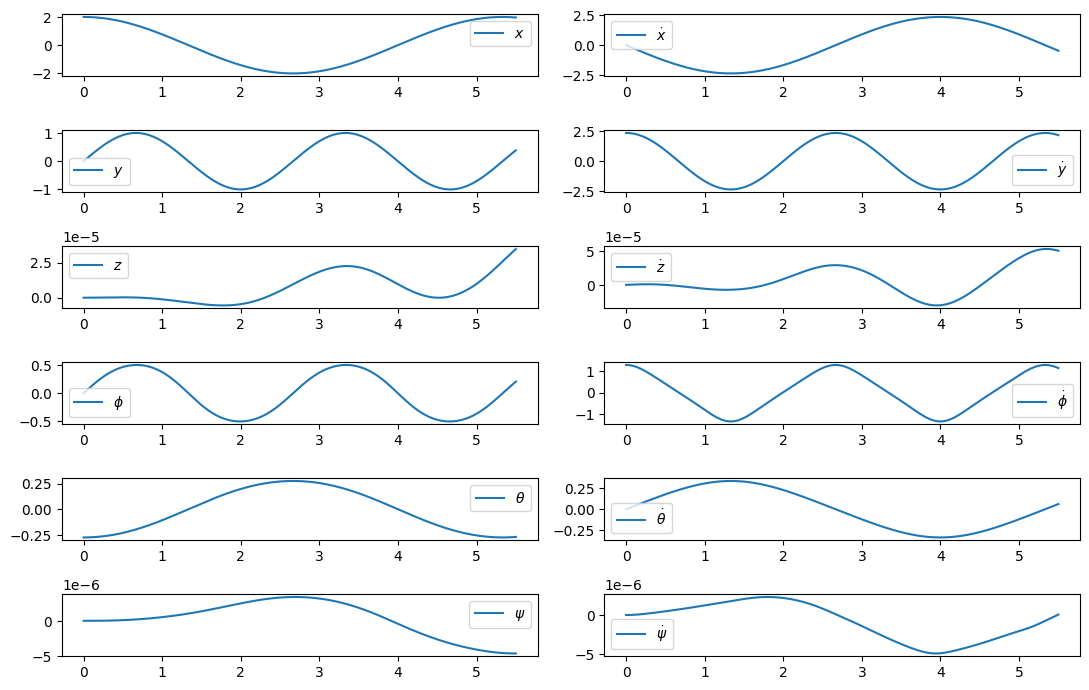

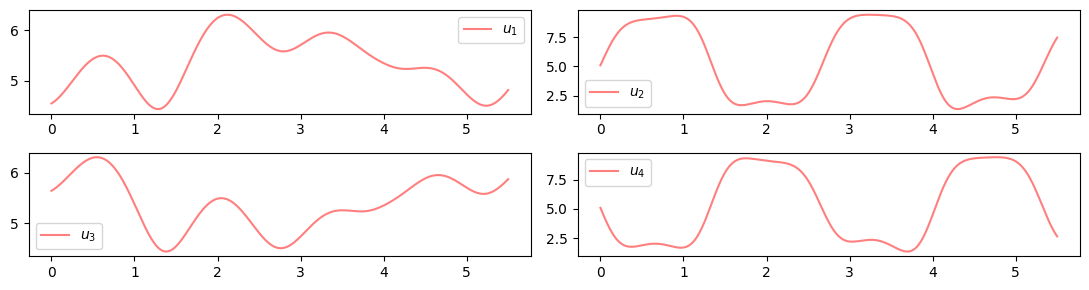

In [9]:
plot_sol(sol)

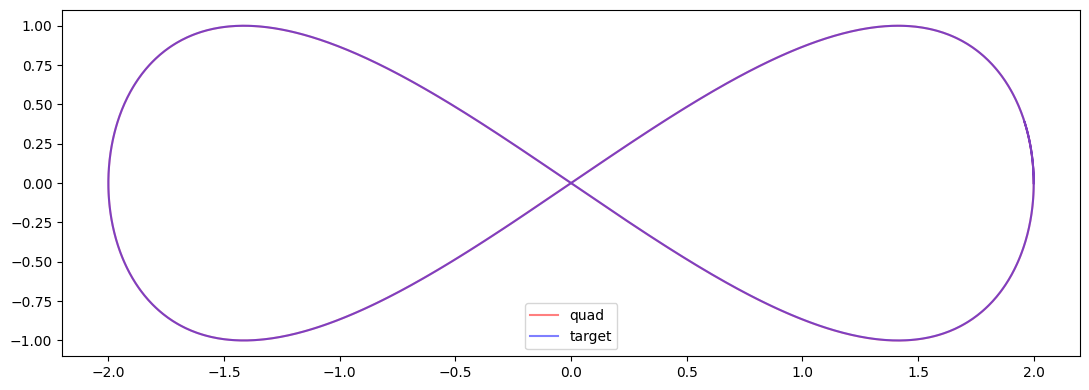

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(
    sol.outputs["state"][:, 0],
    sol.outputs["state"][:, 1],
    "-r",
    alpha=0.5,
    label="quad",
)
ax.plot(x_ref[:, 0], x_ref[:, 1], "-b", alpha=0.5, label="target")
ax.legend(loc="best")
fig.tight_layout()

In [11]:
animate_quadcopter(sol.outputs["state"][:, :6], x_ref[:, :6])

**References**:
> [1] Faessler, M., Franchi, A. and Scaramuzza, D., 2017. Differential flatness of quadrotor dynamics subject to rotor drag for accurate tracking of high-speed trajectories. IEEE Robotics and Automation Letters, 3(2), pp.620-626.
>
> [2] Mellinger, D. and Kumar, V., 2011, May. Minimum snap trajectory generation and control for quadrotors. In 2011 IEEE international conference on robotics and automation (pp. 2520-2525). IEEE.
> 
> [3] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). [Available online.](https://underactuated.csail.mit.edu/)


